In [170]:
import sklearn
from sklearn.metrics import confusion_matrix
import pandas as pd
import os

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cmp


%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.10.14 (main, May  6 2024, 14:42:37) [Clang 14.0.6 ]

NumPy 1.26.4

Matplotlib 3.5.2

TensorFlow 2.16.1
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [171]:
# Load the ImageNet MobileNetv2 model,
model_extractor = tf.keras.applications.MobileNetV2(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))
model_extractor.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
tf.keras.utils.plot_model(model_extractor, to_file = 'MN_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 96)

Found 302 images belonging to 4 classes.
Found 100 images belonging to 4 classes.
type = <class 'numpy.ndarray'> , dtype = float32 , shape = (32, 224, 224, 3) , min(x) = 0.0000 , max(x) = 255.0000
type = <class 'numpy.ndarray'> , dtype = float32 , shape = (32, 4) , min(y) = 0.0000 , max(y) = 1.0000


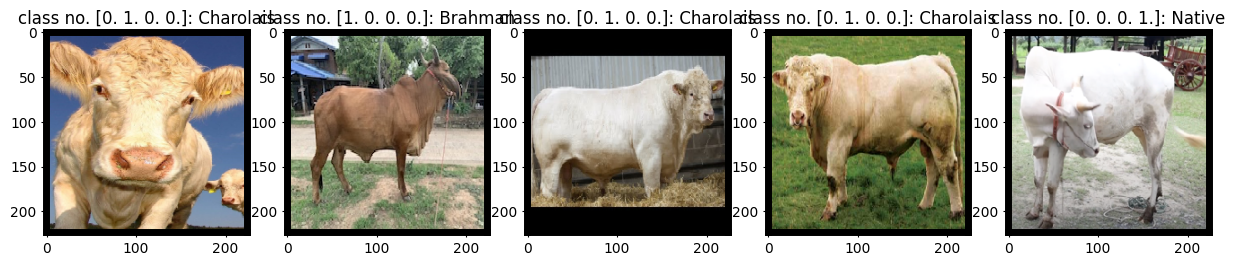

In [172]:
train = '/Users/Lemon/workspace/DL/HW/Datasets/Train'
val = '/Users/Lemon/workspace/DL/HW/Datasets/Validation'
#train = '/Users/wisa/Downloads/DADS/dataset/train'
#val = '/Users/wisa/Downloads/DADS/dataset/validation'

train_datagen = ImageDataGenerator(preprocessing_function=None)
val_datagen = ImageDataGenerator(preprocessing_function=None)

train_set = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),  # Adjust to your image size
    batch_size=32,
    class_mode='categorical'  # Use 'categorical' for one-hot encoded labels
)

val_set = val_datagen.flow_from_directory(
    val,
    target_size=(224, 224),  # Adjust to your image size
    batch_size=32,
    class_mode='categorical'  # Use 'categorical' for one-hot encoded labels
)

labels = ['Brahman', 'Charolais', 'Indo Brazil', 'Native' ]
x_batch, y_batch = next(train_set)

print( f"type = {type(x_batch)} , dtype = {x_batch.dtype} , shape = {x_batch.shape} , min(x) = {np.min(x_batch):.4f} , max(x) = {np.max(x_batch):.4f}" )
print( f"type = {type(y_batch)} , dtype = {y_batch.dtype} , shape = {y_batch.shape} , min(y) = {np.min(y_batch):.4f} , max(y) = {np.max(y_batch):.4f}" )

# Visualize the first five images in x_train
plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(150 + 1 + i).set_title( f"class no. {y_batch[i]}: {labels[ y_batch[i].argmax() ]}" )
    plt.imshow( x_batch[i].astype(np.uint8))
   
    #plt.axis( "off" )
plt.show()


In [173]:
def preprocess_images(generator):
    for batch in generator:
        images, labels = batch
        preprocessed_images = preprocess_input(images)
        yield preprocessed_images, labels

# Apply preprocessing to the training and validation data generators
train_generator= preprocess_images(train_set)
validation_generator = preprocess_images(val_set)

# Get a batch of preprocessed images to inspect
x_batch_vgg, y_batch_vgg = next(train_generator)
xx_batch_vgg, yy_batch_vgg = next(validation_generator)



In [174]:
model_extractor.trainable = False

In [ ]:
from_lay = 151
to_lay = 153

a = model_extractor.layers[from_lay:to_lay+1]

for i in a:
 i.trainable=True

In [ ]:
#model_extractor.trainable = False
# Iterate over all layers in the model
for i,layer in enumerate(model_extractor.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

In [175]:
x = model_extractor.output

# Add our custom layer(s) to the end of the existing model
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x) #512 can be changed to another number before output
x = tf.keras.layers.Dense(256, activation="relu")(x)
#x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x) #10 is number of the total class

# Construct the main model
my_model = tf.keras.models.Model(inputs=model_extractor.inputs, outputs=new_outputs)
my_model.summary()

Model: "functional_89"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 34,519,172 (131.68 MB)

 Trainable params: 32,261,188 (123.07 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
tf.keras.utils.plot_model(my_model, to_file = 'MN_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 96)

In [177]:
my_model.compile( loss="categorical_crossentropy", optimizer="adam", metrics=["acc"] )
#history = model.fit( x_train_vgg, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2 )
steps_per_epoch = max(1, train_set.samples // train_set.batch_size)
validation_steps = max(1, val_set.samples // val_set.batch_size)


print(f"Total training samples: {train_set.samples}")
print(f"Total validation samples: {val_set.samples}")
print(f'Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}')

# Fit the model
history = my_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=validation_steps)

Total training samples: 302
Total validation samples: 100
Steps per epoch: 9, Validation steps: 3
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - acc: 0.2677 - loss: 6.8941 - val_acc: 0.6912 - val_loss: 1.5248
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - acc: 0.5881 - loss: 3.2492 - val_acc: 0.7917 - val_loss: 0.5888
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - acc: 0.7207 - loss: 1.0697 - val_acc: 0.7353 - val_loss: 0.6180
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - acc: 0.7531 - loss: 0.6733 - val_acc: 0.7941 - val_loss: 0.5204
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - acc: 0.7835 - loss: 0.5957 - val_acc: 0.8676 - val_loss: 0.3578
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - acc: 0.8187 - loss: 0.4286 - val_acc: 0.7812 - val_loss: 0.6533
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - acc: 0.8708 - loss: 0.6101 - val_acc: 0.8382 - val_loss: 0.4911
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - acc: 0.8354 - loss: 0.3804 - val_acc: 0.

In [178]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
last_conv_layer_name = "out_relu"

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
          last_conv_layer_output, preds = grad_model(img_array)
          if pred_index is None:
              pred_index = tf.argmax(preds[0])
          class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
    
def save_and_display_gradcam(img_path, heatmap, cam_path="cam_mn.jpg", alpha=0.4):
      img = img_path

      # Rescale heatmap to a range 0-255
      heatmap = np.uint8(255 * heatmap)

      # Use jet colormap to colorize heatmap
      jet = plt.get_cmap("jet")

      # Use RGB values of the colormap
      jet_colors = jet(np.arange(256))[:, :3]
      jet_heatmap = jet_colors[heatmap]

      # Create an image with RGB colorized heatmap
      jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
      jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
      jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

      # Superimpose the heatmap on original image
      superimposed_img = jet_heatmap * alpha + img
      superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

      # Save the superimposed image
      superimposed_img.save(cam_path)
      display(Image(cam_path))

samples.shape=(16, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


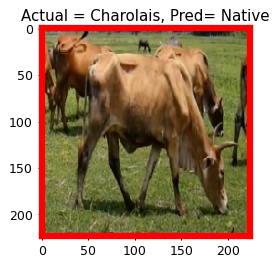

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


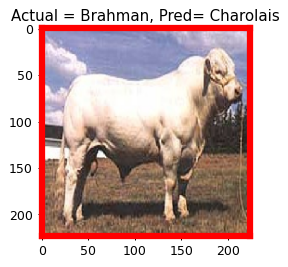

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


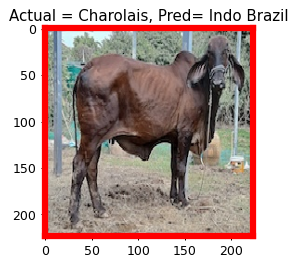

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


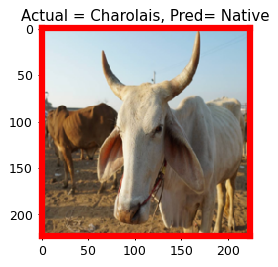

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


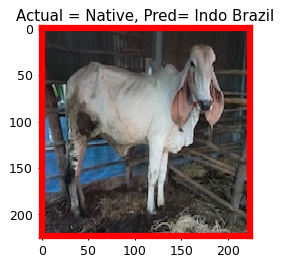

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


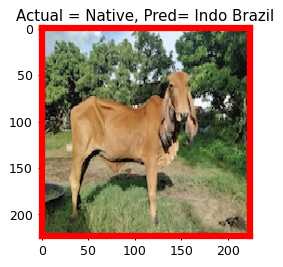

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


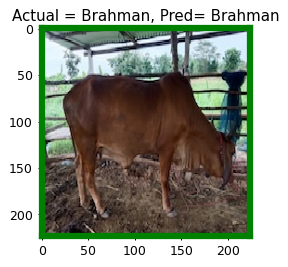

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


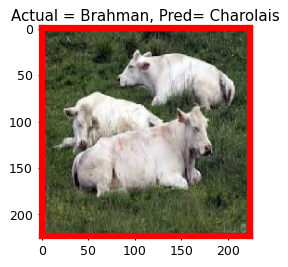

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


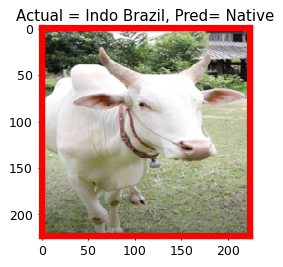

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


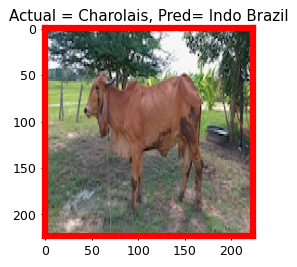

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


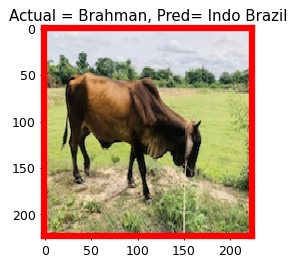

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


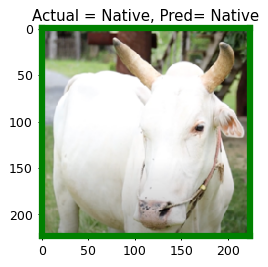

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


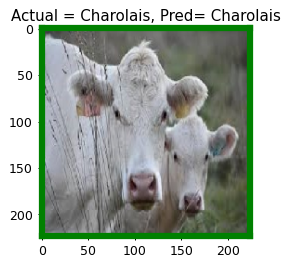

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


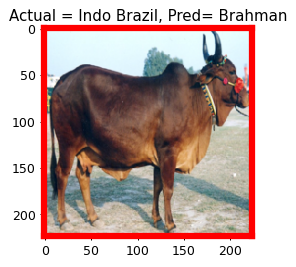

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


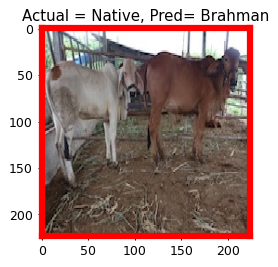

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


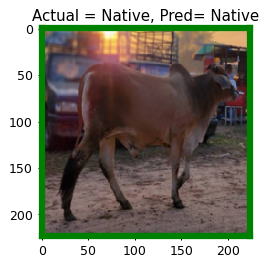

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [179]:
plt.rcParams["axes.linewidth"] = 5
def color_frame(ax, true_label, pred_label):
    if true_label == pred_label:
        color = 'green'
    else:
        color = 'red'
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(5)

n = 16
#samples = x_batch[:n]
samples = xx_batch_vgg[:n]


print(f'{samples.shape=}')

# Predict a batch of samples
y_pred = my_model.predict(samples)

# Interpret the results
for i in range(n):
    plt.figure(figsize=(3, 3), dpi=90)
    ax = plt.gca() 
    show_img = tf.keras.preprocessing.image.array_to_img(samples[i])   
    plt.imshow(show_img)
    true_label = int(np.argmax(y_batch[i]))
    pred_label = int(np.argmax(y_pred[i]))
    plt.title(f"Actual = {labels[true_label]}, Pred= {labels[pred_label]}")
    color_frame(ax, true_label, pred_label)
    plt.show()
    #c= np.random.randint(0,16)
    img_path = samples[i]
    img_array = preprocess_input(img_path)
    my_model.layers[-1].activation = None
    preds = my_model.predict(img_array.reshape(-1,224,224,3))
    true_label = int(np.argmax(y_batch[i]))
    pred_label = int(np.argmax(y_pred[i]))
    #plt.title(f"Actual = {labels[true_label]}, Pred= {labels[pred_label]}")
    #print(f"Predicted: {labels[np.argmax(preds)]} | Actual: {labels[y_batch_t[c]]} ")
    #print(f'Actual = {labels[true_label]}, Pred= {labels[pred_label]}')
    #heatmap = make_gradcam_heatmap(img_array.reshape(1,224,224,3), my_model, last_conv_layer_name)
    #save_and_display_gradcam(img_path, heatmap)
    
    


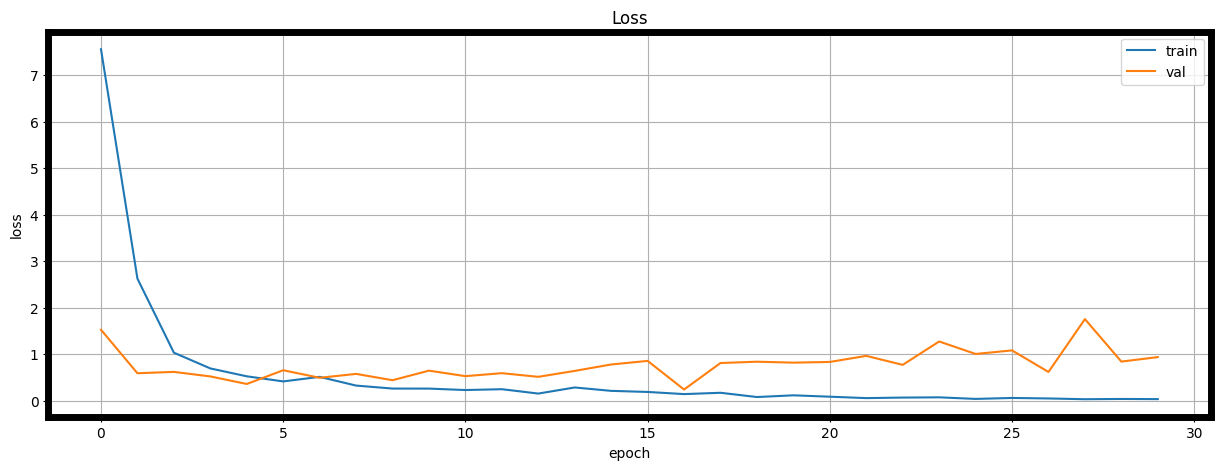

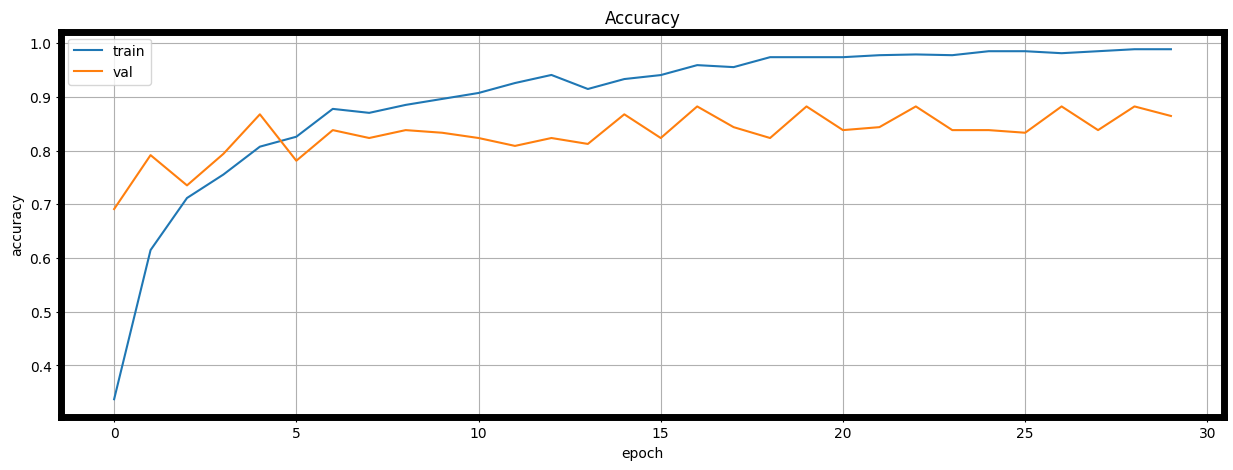

In [180]:
# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [181]:
results = my_model.evaluate(xx_batch_vgg, yy_batch_vgg, batch_size=32)
print( f"{my_model.metrics_names}: {results}" )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - acc: 0.5625 - loss: 1.5244
['loss', 'compile_metrics']: [1.5243971347808838, 0.5625]


In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
last_conv_layer_name = "out_relu"

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
          last_conv_layer_output, preds = grad_model(img_array)
          if pred_index is None:
              pred_index = tf.argmax(preds[0])
          class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
    
def save_and_display_gradcam(img_path, heatmap, cam_path="cam_mn.jpg", alpha=0.4):
      img = img_path

      # Rescale heatmap to a range 0-255
      heatmap = np.uint8(255 * heatmap)

      # Use jet colormap to colorize heatmap
      jet = plt.get_cmap("jet")

      # Use RGB values of the colormap
      jet_colors = jet(np.arange(256))[:, :3]
      jet_heatmap = jet_colors[heatmap]

      # Create an image with RGB colorized heatmap
      jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
      jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
      jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

      # Superimpose the heatmap on original image
      superimposed_img = jet_heatmap * alpha + img
      superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

      # Save the superimposed image
      superimposed_img.save(cam_path)
      display(Image(cam_path))

      # Display Grad CAM
      #display(Image(plt.imshow(superimposed_img)[0]))
'''for i in range(5):
  c= np.random.randint(0,16)
  img_path = x_batch_vgg[c]
  img_array = preprocess_input(img_path)
  my_model.layers[-1].activation = None
  preds = my_model.predict(img_array.reshape(-1,224,224,3))
  true_label = int(np.argmax(y_batch[i]))
  pred_label = int(np.argmax(y_pred[i]))
  #plt.title(f"Actual = {labels[true_label]}, Pred= {labels[pred_label]}")
  #print(f"Predicted: {labels[np.argmax(preds)]} | Actual: {labels[y_batch_t[c]]} ")
  print(f'Actual = {labels[true_label]}, Pred= {labels[pred_label]}')
  heatmap = make_gradcam_heatmap(img_array.reshape(1,224,224,3), my_model, last_conv_layer_name)
  save_and_display_gradcam(img_path, heatmap)
  """